# Fine-Tuning BERT Transformers For Text Classification
## Introduction
In the realm of medical research and diagnostics, the classification and analysis of cancer-related data hold immense importance. Leveraging state-of-the-art natural language processing (NLP) techniques, this project endeavors to classify textual data associated with cancer-related information using BERT (Bidirectional Encoder Representations from Transformers) - a powerful language model developed by Google.

## Objective
The primary goal of this project is to harness the capabilities of BERT, made conveniently accessible via Hugging Face's transformers library, to perform text classification on cancer-related textual information. By fine-tuning a pre-trained BERT model on a specialized dataset curated for this purpose, the aim is to create a robust classifier capable of categorizing textual data into relevant cancer-related categories or classes.

Dataset Link: https://www.kaggle.com/datasets/falgunipatel19/biomedical-text-publication-classification

BERT Model Link: https://huggingface.co/distilbert-base-uncased

## Installing transformers library

In [1]:
!pip install transformers

## Importing all required library

In [3]:
import pandas as pd
import tensorflow as tf
import transformers
from transformers import DistilBertTokenizer,TFDistilBertForSequenceClassification,TFTrainer,TFTrainingArguments
from sklearn.model_selection import train_test_split
import zipfile
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

## Importing Dataset From Kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d falgunipatel19/biomedical-text-publication-classification

!chmod 600 /root/.kaggle/kaggle.json

100% 55.9M/55.9M [00:04<00:00, 20.0MB/s]
100% 55.9M/55.9M [00:04<00:00, 14.2MB/s]


In [5]:
zip_ref = zipfile.ZipFile('/content/biomedical-text-publication-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
dataset = pd.read_csv("/content/alldata_1_for_kaggle.csv",encoding='latin1')

## Data Preprocessing and Data Analysis

In [7]:
dataset.head()

,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [8]:
dataset = dataset[['0','a']]

In [9]:
dataset.head()

,0,a
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [10]:
dataset.rename(columns = {"0":"Output","a":"Text"},inplace = True)

In [11]:
dataset.head()

,Output,Text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [12]:
dataset.shape

(7570, 2)

In [13]:
dataset['Output'].value_counts()

Thyroid_Cancer    2810
Colon_Cancer      2580
Lung_Cancer       2180
Name: Output, dtype: int64

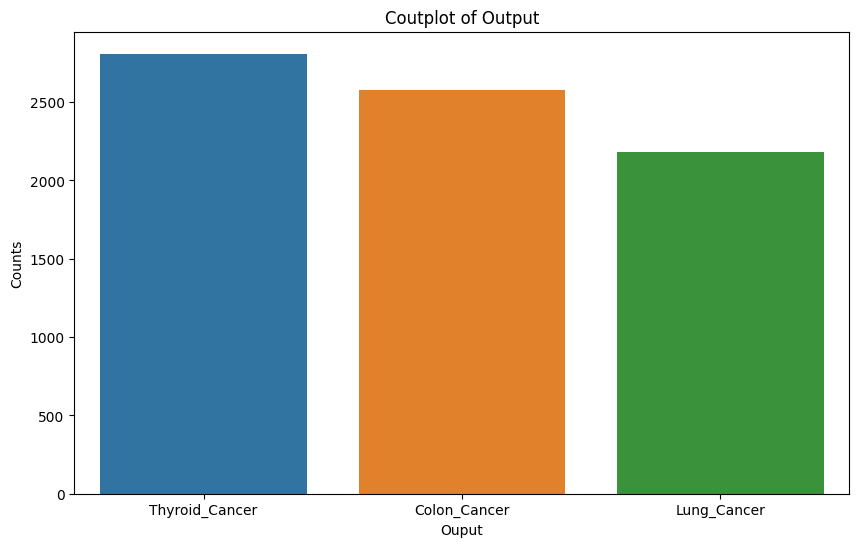

In [14]:
plt.figure(figsize = (10,6))
sns.countplot(data = dataset,x = "Output")
plt.title("Coutplot of Output")
plt.xlabel("Ouput")
plt.ylabel("Counts")
plt.show()

In [16]:
dataset['Encode Output'] = dataset['Output'].astype("category").cat.codes

In [17]:
dataset.head()

,Output,Text,Encode Output
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,2
1,Thyroid_Cancer,""" The adopted strategy was the same as that us...",2
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,2
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,2
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,2


In [18]:
x = dataset['Text'].to_list()
y = dataset['Encode Output'].to_list()

In [24]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size = 0.3,random_state = 4)

x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size = 0.01,random_state= 3)

## Model Building, Training and Evaluation

In [25]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_encode = tokenizer(x_train , truncation = True, padding = True)
validation_encode = tokenizer(x_val , truncation = True, padding = True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encode),y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((dict(validation_encode),y_val))

In [27]:
training_args = TFTrainingArguments(
    output_dir = './results',
    num_train_epochs = 2,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 16,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = './logs',
    logging_steps = 10,
    eval_steps = 500
)

In [28]:
with training_args.strategy.scope():
  model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels = 3)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [31]:
trainer = TFTrainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = validation_dataset
)

/usr/local/lib/python3.10/dist-packages/transformers/trainer_tf.py:118: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow
  warnings.warn(


In [32]:
trainer.train()

In [33]:
trainer.evaluate()

{'eval_loss': 0.09012392205251775}

## Save the Model

In [34]:
save_location = "trained_model"

model.save_pretrained(save_location)
tokenizer.save_pretrained(save_location)

('trained_model/tokenizer_config.json',
 'trained_model/special_tokens_map.json',
 'trained_model/vocab.txt',
 'trained_model/added_tokens.json')

## Load The Model

In [35]:
tokenizer_trained_model = DistilBertTokenizer.from_pretrained(save_location)
trained_model = TFDistilBertForSequenceClassification.from_pretrained(save_location)

Some layers from the model checkpoint at trained_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at trained_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Predicting Output on test and custom data

In [64]:
import numpy as np

def predictive_system(input_text):

  ans_class = ['Colon Cancer','Lung Cancer','Thyroid Cancer']

  predict_output = tokenizer_trained_model.encode(input_text, truncation=True , padding = True , return_tensors= "tf")

  output = trained_model.predict(predict_output)[0]

  return ans_class[np.argmax(output)]


In [65]:
# with test data
print("Prdicted Output: ",predictive_system(x_test[0]))
print("Actual Output: ",y_test[0])

1/1 [==============================] - 0s 53ms/step
Prdicted Output:  Thyroid Cancer
Actual Output:  2


In [66]:
# with custom data

text = "Your lungs are infected because of over-smoking and you have to treatment it as soon as possible."
print("Output: ",predictive_system(text))

1/1 [==============================] - 0s 34ms/step
Output:  Lung Cancer
